<a href="https://colab.research.google.com/github/dviva1972/denvlaiva/blob/master/DLL_hw_3__1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DLL

## Домашняя работа 3  |  Сверточные нейронные сети

## Иванов Денис

### Задача: Используя сверточные слои и архитектуру получите на fashion mnist качество не ниже 89,5%

In [ ]:
import torch
from torchvision import datasets, transforms
from torch import nn, optim

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import time

In [ ]:
BATCH_SIZE = 64

train_dataset    = datasets.FashionMNIST('.', download = True, train = True, 
                                         transform = transforms.ToTensor())
test_dataset     = datasets.FashionMNIST('.', download = True, train = False, 
                                         transform = transforms.ToTensor())

train_iter = torch.utils.data.DataLoader(train_dataset, 
                                        batch_size = BATCH_SIZE, shuffle = True)
test_iter  = torch.utils.data.DataLoader(test_dataset,  
                                        batch_size = BATCH_SIZE, shuffle = False)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


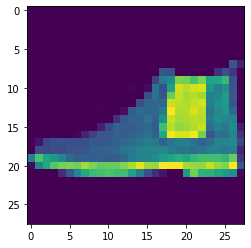

In [ ]:
plt.imshow(train_dataset[111][0].numpy().reshape(28,28))

In [ ]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dev

device(type='cuda')

In [ ]:
def train(net, train_iter, test_iter, trainer, num_epochs, dev):
    loss = nn.CrossEntropyLoss(reduction='sum')
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(dev), y.to(dev)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net, dev)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc,
                 time.time() - start))

In [ ]:
def evaluate_accuracy(data_iter, net, dev):
    acc_sum, n = torch.Tensor([0]).to(dev), 0
    for X, y in data_iter:
        X, y = X.to(dev), y.to(dev)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

#### Решение № 1

In [ ]:
model = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(3, stride=1),
    nn.Conv2d(6, 12, kernel_size=4),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Flatten(),
    nn.Linear(1452, 502),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(502, 51),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(51, 10)
)

In [ ]:
X = train_dataset[0][0]
X = X.reshape(1, 1, 28, 28)
print(X.shape)
for l in model:
    X = l(X)
    print("Layer {}. X shape: {}".format(l, X.shape))

torch.Size([1, 1, 28, 28])
Layer Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)). X shape: torch.Size([1, 6, 28, 28])
Layer ReLU(). X shape: torch.Size([1, 6, 28, 28])
Layer MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False). X shape: torch.Size([1, 6, 26, 26])
Layer Conv2d(6, 12, kernel_size=(4, 4), stride=(1, 1)). X shape: torch.Size([1, 12, 23, 23])
Layer ReLU(). X shape: torch.Size([1, 12, 23, 23])
Layer MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False). X shape: torch.Size([1, 12, 11, 11])
Layer Flatten(start_dim=1, end_dim=-1). X shape: torch.Size([1, 1452])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Layer Linear(in_features=1452, out_features=502, bias=True). X shape: torch.Size([1, 502])
Layer ReLU(). X shape: torch.Size([1, 502])
Layer Dropout(p=0.5, inplace=False). X shape: torch.Size([1, 502])
Layer Linear(in_features=502, out_features=51, bias=True). X shape: torch.Size([1, 51])
Layer ReLU(). X shape: torch.Size([1, 51])
Layer Dropout(p=0.3, inplace=False). X shape: torch.Size([1, 51])
Layer Linear(in_features=51, out_features=10, bias=True). X shape: torch.Size([1, 10])


In [ ]:
model = model.to(dev)
lr, num_epochs = 0.0015, 15
trainer = torch.optim.SGD(model.parameters(), lr=lr)
train(model, train_iter, test_iter, trainer, num_epochs, dev)

epoch 1, loss 0.8835, train acc 0.655, test acc 0.762, time 7.5 sec
epoch 2, loss 0.5335, train acc 0.803, test acc 0.820, time 7.2 sec
epoch 3, loss 0.4439, train acc 0.841, test acc 0.844, time 7.2 sec
epoch 4, loss 0.3980, train acc 0.859, test acc 0.848, time 7.3 sec
epoch 5, loss 0.3630, train acc 0.870, test acc 0.865, time 7.3 sec
epoch 6, loss 0.3338, train acc 0.881, test acc 0.877, time 7.2 sec
epoch 7, loss 0.3183, train acc 0.887, test acc 0.880, time 7.2 sec
epoch 8, loss 0.3006, train acc 0.889, test acc 0.881, time 7.2 sec
epoch 9, loss 0.2864, train acc 0.897, test acc 0.885, time 7.3 sec
epoch 10, loss 0.2746, train acc 0.900, test acc 0.879, time 7.3 sec
epoch 11, loss 0.2603, train acc 0.906, test acc 0.892, time 7.3 sec
epoch 12, loss 0.2531, train acc 0.908, test acc 0.883, time 7.2 sec
epoch 13, loss 0.2448, train acc 0.911, test acc 0.891, time 7.2 sec
epoch 14, loss 0.2349, train acc 0.914, test acc 0.889, time 7.3 sec
epoch 15, loss 0.2285, train acc 0.916, tes

#### Решение № 2

In [ ]:
model = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=3, padding=1),
    nn.BatchNorm2d(6),
    nn.ReLU(),
    nn.MaxPool2d(3, stride=1),
    nn.Conv2d(6, 12, kernel_size=4),
    nn.BatchNorm2d(12),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Flatten(),
    nn.Linear(1452, 502),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(502, 51),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(51, 10)
)

In [ ]:
X = train_dataset[0][0]
X = X.reshape(1, 1, 28, 28)
print(X.shape)
for l in model:
    X = l(X)
    print("Layer {}. X shape: {}".format(l, X.shape))

torch.Size([1, 1, 28, 28])
Layer Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)). X shape: torch.Size([1, 6, 28, 28])
Layer BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True). X shape: torch.Size([1, 6, 28, 28])
Layer ReLU(). X shape: torch.Size([1, 6, 28, 28])
Layer MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False). X shape: torch.Size([1, 6, 26, 26])
Layer Conv2d(6, 12, kernel_size=(4, 4), stride=(1, 1)). X shape: torch.Size([1, 12, 23, 23])
Layer BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True). X shape: torch.Size([1, 12, 23, 23])
Layer ReLU(). X shape: torch.Size([1, 12, 23, 23])
Layer MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False). X shape: torch.Size([1, 12, 11, 11])
Layer Flatten(start_dim=1, end_dim=-1). X shape: torch.Size([1, 1452])
Layer Linear(in_features=1452, out_features=502, bias=True). X shape: torch.Size([1, 502])
Layer ReLU(). X shape: torc

In [ ]:
model = model.to(dev)
lr, num_epochs = 0.001, 12
loss    = nn.CrossEntropyLoss()
trainer = torch.optim.Adam(model.parameters(), lr=lr)
train(model, train_iter, test_iter, trainer, num_epochs, dev)

epoch 1, loss 0.5206, train acc 0.813, test acc 0.856, time 8.1 sec
epoch 2, loss 0.3608, train acc 0.871, test acc 0.873, time 8.1 sec
epoch 3, loss 0.3163, train acc 0.885, test acc 0.884, time 8.1 sec
epoch 4, loss 0.2920, train acc 0.895, test acc 0.884, time 8.0 sec
epoch 5, loss 0.2708, train acc 0.903, test acc 0.887, time 8.1 sec
epoch 6, loss 0.2534, train acc 0.909, test acc 0.891, time 8.2 sec
epoch 7, loss 0.2366, train acc 0.914, test acc 0.897, time 8.0 sec
epoch 8, loss 0.2294, train acc 0.918, test acc 0.898, time 8.0 sec
epoch 9, loss 0.2137, train acc 0.921, test acc 0.903, time 8.0 sec
epoch 10, loss 0.2054, train acc 0.924, test acc 0.900, time 8.1 sec
epoch 11, loss 0.1963, train acc 0.929, test acc 0.901, time 8.1 sec
epoch 12, loss 0.1876, train acc 0.931, test acc 0.904, time 8.0 sec


#### Решение № 3

In [ ]:
model = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=3, padding=1),
    nn.BatchNorm2d(6),
    nn.ReLU(),
    nn.AvgPool2d(3, stride=1),
    nn.Conv2d(6, 12, kernel_size=4),
    nn.BatchNorm2d(12),
    nn.ReLU(),
    nn.AvgPool2d(2, stride=2),
    nn.Flatten(),    
    nn.Linear(1452, 302),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(302, 62),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(62, 10)
)

In [ ]:
X = train_dataset[0][0]
X = X.reshape(1, 1, 28, 28)
print(X.shape)
for l in model:
    X = l(X)
    print("Layer {}. X shape: {}".format(l, X.shape))

torch.Size([1, 1, 28, 28])
Layer Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)). X shape: torch.Size([1, 6, 28, 28])
Layer BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True). X shape: torch.Size([1, 6, 28, 28])
Layer ReLU(). X shape: torch.Size([1, 6, 28, 28])
Layer AvgPool2d(kernel_size=3, stride=1, padding=0). X shape: torch.Size([1, 6, 26, 26])
Layer Conv2d(6, 12, kernel_size=(4, 4), stride=(1, 1)). X shape: torch.Size([1, 12, 23, 23])
Layer BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True). X shape: torch.Size([1, 12, 23, 23])
Layer ReLU(). X shape: torch.Size([1, 12, 23, 23])
Layer AvgPool2d(kernel_size=2, stride=2, padding=0). X shape: torch.Size([1, 12, 11, 11])
Layer Flatten(start_dim=1, end_dim=-1). X shape: torch.Size([1, 1452])
Layer Linear(in_features=1452, out_features=302, bias=True). X shape: torch.Size([1, 302])
Layer ReLU(). X shape: torch.Size([1, 302])
Layer Dropout(p=0.3, inplace=False). X sh

In [ ]:
model = model.to(dev)
lr, num_epochs = 0.0004, 10
loss    = nn.CrossEntropyLoss()
trainer = torch.optim.Adam(model.parameters(), lr=lr)
train(model, train_iter, test_iter, trainer, num_epochs, dev)

epoch 1, loss 0.5611, train acc 0.800, test acc 0.841, time 7.9 sec
epoch 2, loss 0.3683, train acc 0.867, test acc 0.871, time 7.9 sec
epoch 3, loss 0.3193, train acc 0.885, test acc 0.884, time 8.0 sec
epoch 4, loss 0.2881, train acc 0.896, test acc 0.887, time 7.9 sec
epoch 5, loss 0.2690, train acc 0.903, test acc 0.889, time 7.9 sec
epoch 6, loss 0.2519, train acc 0.909, test acc 0.896, time 8.0 sec
epoch 7, loss 0.2372, train acc 0.913, test acc 0.898, time 7.9 sec
epoch 8, loss 0.2255, train acc 0.918, test acc 0.899, time 8.1 sec
epoch 9, loss 0.2164, train acc 0.921, test acc 0.907, time 8.0 sec
epoch 10, loss 0.2054, train acc 0.924, test acc 0.907, time 7.9 sec
